In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import pidly
import astropy.stats as stats
import astropy.constants as const
datadir = '/Volumes/SD-Mac/Google Drive/research/bhr71_infall/analysis/imcontsub/'

In [4]:
linelist = ['HCN 4-3', 'HCO$^{+}$ 4-3', 'CS 7-6', 'H$^{13}$CN 4-3']
restfreqs = [354.505473, 356.734242, 342.882857, 345.339756]
source_v = -4.45  # km/s

#### Find peaks

In [5]:
spec = ascii.read(datadir+'spw0.imcontsub.scriptExtraction.txt',
                  names=['Channel','number_of_unmasked_pixels','frequency_(MHz)','Velocity_(km/s)','Flux_density_(Jy)'])
freqres = np.mean(spec['frequency_(MHz)'][1:]-spec['frequency_(MHz)'][:-1])  # in MHz

def vlsr_correction(freq, vlsr):
    """
    freq: the frequency array of spectrum
    vlsr: the vlsr of source in the unit of km/s
    """
    
    c = 29979245800.0
    return freq + freq*(vlsr*1e5)/c

vlsr = -4.45
spec['frequency_corrected_(MHz)'] = vlsr_correction(spec['frequency_(MHz)'], vlsr)

In [34]:
center_mask = (spec['Velocity_(km/s)'] < source_v-10) + (spec['Velocity_(km/s)'] > source_v+10)
spec_clipped = stats.sigma_clip(spec['Flux_density_(Jy)'][center_mask], sigma=2.5, copy=True)

In [35]:
# group the found peaks (take only positive fluxes)
positive_peaks = spec['frequency_corrected_(MHz)'][center_mask][spec_clipped.mask][spec['Flux_density_(Jy)'][center_mask][spec_clipped.mask] >= 0]
peak_groups = []
group_dum = [positive_peaks[0]]

# group the peaks by their continuity
for p in positive_peaks[1:]:
    if p-group_dum[-1] <= freqres*3:
        group_dum.append(p)
    else:
        peak_groups.append(group_dum)
        group_dum = [p]

# take mean value among each group
peak_val = []
for g in peak_groups:
    peak_val.append(np.mean(g))
    
peak_val = np.array(peak_val)

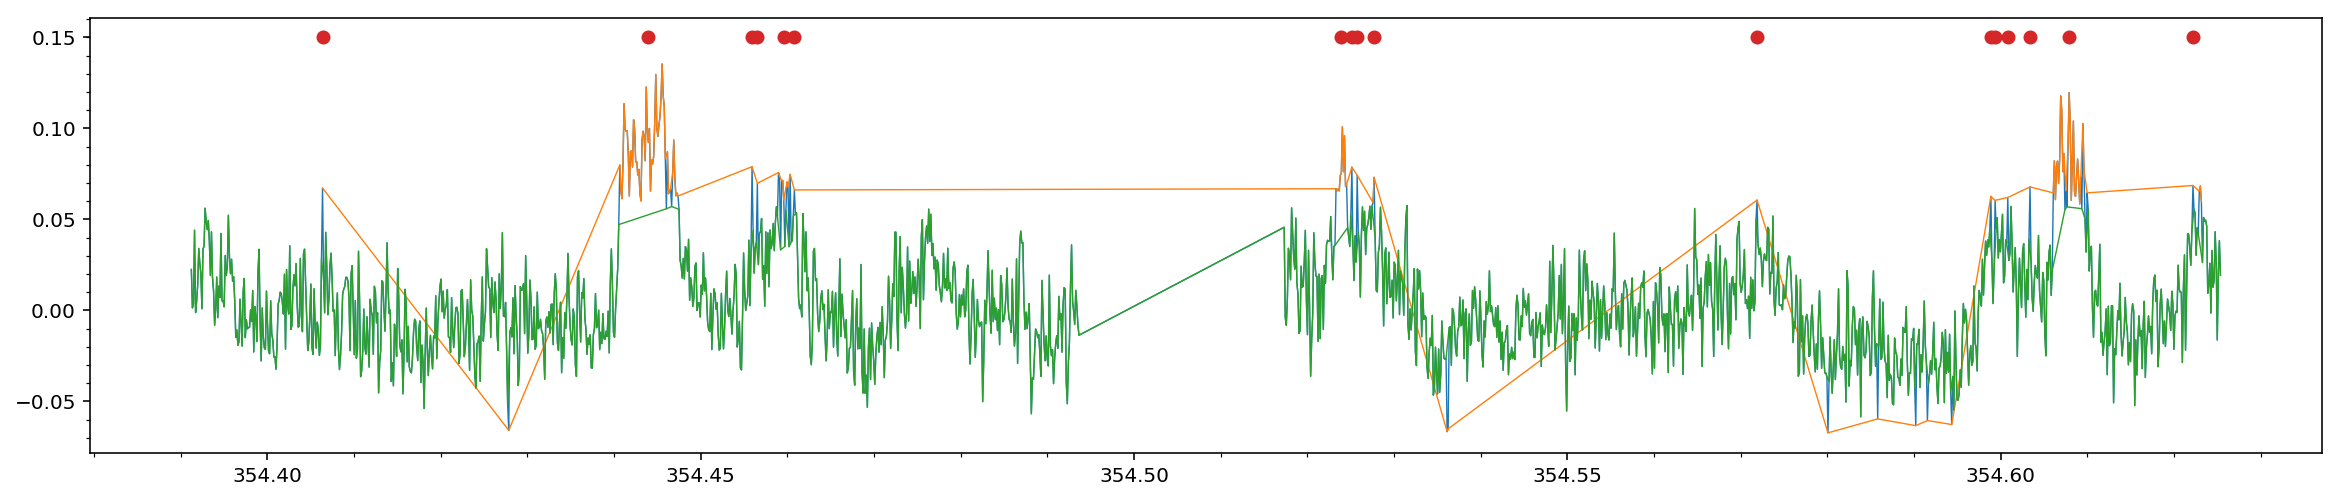

In [49]:
# quick plot the spectrum
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(111)
# ax.plot(spec['frequency_(MHz)']/1e3, spec['Flux_density_(Jy)'], linewidth=0.7)
ax.plot(spec['frequency_corrected_(MHz)'][center_mask]/1e3, spec['Flux_density_(Jy)'][center_mask], linewidth=0.7)
ax.plot(spec['frequency_corrected_(MHz)'][center_mask][spec_clipped.mask]/1e3, spec['Flux_density_(Jy)'][center_mask][spec_clipped.mask], linewidth=0.7)
ax.plot(spec['frequency_corrected_(MHz)'][center_mask][spec_clipped.mask == False]/1e3, spec['Flux_density_(Jy)'][center_mask][spec_clipped.mask == False], linewidth=0.7)
ax.plot(peak_val/1e3, np.ones_like(peak_val)*0.15, 'o')

ax.minorticks_on()
# ax.set_xlim([354.43, 354.45])

In [45]:
df = 0.1*1e5/const.c.cgs.value*354.505473
line_center = peak_val
line_name = ['{:<8.4f}'.format(f/1e3) for f in peak_val]

foo = open('/Users/yaolun/GoogleDrive/research/bhr71_infall/analysis/imcontsub/spw0.imcontsub.scriptExtraction.fittingInfo.txt', 'w')
for i, (name, center) in enumerate(zip(line_name, line_center)):
    foo.write('{:<12s}  {:<16.9f}  {:<6.2f}  {:<6.2f}  {:<6.2f}  {:<6.2f}  {:<6.2e}\n'.format(name, center/1e3, 354.41, 354.43, 354.54, 354.56, df))
foo.close()

In [41]:
foo = open('/Users/yaolun/GoogleDrive/research/bhr71_infall/analysis/imcontsub/spw0.imcontsub.scriptExtraction.forFitting.txt', 'w')
for i, (freq, flux) in enumerate(zip(spec['frequency_corrected_(MHz)'][center_mask], spec['Flux_density_(Jy)'][center_mask])):
    foo.write('{:<14.9f}  {:<14.9f}\n'.format(freq/1e3, flux))
foo.close()

#### output spectra for XCLASS

In [1]:
spws = ['0','1','2','3']
datadir = '/Volumes/SD-Mac/Google Drive/research/bhr71_infall/analysis/imcontsub/'
from astropy.io import ascii
import numpy as np

def vlsr_correction(freq, vlsr):
    """
    freq: the frequency array of spectrum
    vlsr: the vlsr of source in the unit of km/s
    """
    
    c = 29979245800.0
    return freq + freq*(vlsr*1e5)/c


# the size of extracted region
region = (0.5213, 0.394)

# not sure this is correct
def Sjy2t(freq, beam=(0.4, 0.28)):
    s_maj, s_min = beam
    return 13.6*(300/freq)**2/s_maj/s_min

linelist = ['HCN 4-3', 'HCO$^{+}$ 4-3', 'CS 7-6', 'H$^{13}$CN 4-3']
restfreqs = [354.505473, 356.734242, 342.882857, 345.339756]
vlsr = -4.45


for i, spw in enumerate(spws):
    spec = ascii.read(datadir+'spw'+spw+'.imcontsub.scriptExtraction.txt',
                      names=['Channel','number_of_unmasked_pixels','frequency_(MHz)','Velocity_(km/s)','Flux_density_(Jy)'])

    spec['frequency_corrected_(MHz)'] = vlsr_correction(spec['frequency_(MHz)'], vlsr)
    spec['Temperature_(K)'] = Sjy2t(restfreqs[i], beam=region)*spec['Flux_density_(Jy)']

    foo = open('/Users/yaolun/GoogleDrive/research/bhr71_infall/analysis/imcontsub/spw'+spw+'.imcontsub.scriptExtraction.forXCLASS.txt', 'w')
    for i, (freq, flux) in enumerate(zip(spec['frequency_corrected_(MHz)'], spec['Temperature_(K)'])):
        foo.write('{:<14.9f}  {:<14.9f}\n'.format(freq, flux))
    foo.close()

### Solve the header issue for output the spectra within a given region in FITS format

What is the header written by CASA viewer look like?

In [7]:
from astropy.io import fits, ascii
import numpy as np

spws = ['0','1','2','3']
linelist = ['HCN 4-3', 'HCO$^{+}$ 4-3', 'CS 7-6', 'H$^{13}$CN 4-3']
restfreqs = [354.505473, 356.734242, 342.882857, 345.339756]
vlsr = -4.45

# the size of extracted region
region = (0.5213, 0.394)

# not sure this is correct
def Sjy2t(freq, beam=(0.4, 0.28)):
    s_maj, s_min = beam
    return 13.6*(300/freq)**2/s_maj/s_min

for i, spw in enumerate(spws):
    hdu = fits.open('/Users/yaolun/GoogleDrive/research/bhr71_infall/analysis/spw'+spw+'.spec.viewer.fits')
    hdr = hdu[0].header
    spec = ascii.read('/Users/yaolun/GoogleDrive/research/bhr71_infall/analysis/imcontsub/spw'+spw+'.imcontsub.scriptExtraction.txt',
                      names=['Channel','number_of_unmasked_pixels','frequency_(MHz)','Velocity_(km/s)','Flux_density_(Jy)'])
    spec['frequency_corrected_(MHz)'] = vlsr_correction(spec['frequency_(MHz)'], vlsr)
    spec['Temperature_(K)'] = Sjy2t(restfreqs[i], beam=region)*spec['Flux_density_(Jy)']
    
#     print(np.shape(hdu[0].data))
#     print(np.shape(spec['Temperature_(K)']))
    
#     hdu[0].data = spec['Temperature_(K)'].data
    
    primary_hdu = fits.PrimaryHDU(spec['Temperature_(K)'].data.astype('float32'), header=hdr)
    hdu_out = fits.HDUList([primary_hdu])
    hdu_out.writeto('/Users/yaolun/GoogleDrive/research/bhr71_infall/analysis/imcontsub/spw'+spw+'.imcontsub.scriptExtraction.class.fits', overwrite=True)